### Natural language processing.

- Find out most common words overall.

- Find out distribution of text length.

- Find out important words using TF-IDF

In [0]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pyspark.sql.functions as f
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import plotly.express as px
import numpy as np

We use top 5 most popular Pokemon subreddits to perform NLP tasks, including "pokemongo", "pokemon", "pokemontrades", "PokemonTCG", "PokemonSwordAndShield". According to the result in EDA, these 5 subreddits contain about 11 million comments.

In [0]:
pokemon_comments = spark.read.parquet("/FileStore/pokemon_comments")

# select top 5 subreddits
top5_subreddit = ['pokemongo','pokemon','pokemontrades','PokemonTCG','PokemonSwordAndShield']
top_pokemon = pokemon_comments.filter(f.col("subreddit").isin(top5_subreddit)).select("subreddit", "body", "created_utc", "score")

Count common words overall.

In [0]:
# split sentence into words and count word occurrence
words_count = top_pokemon.withColumn('word', f.explode(f.split(f.col('body'), ' '))) \
    .groupBy('word') \
    .agg(f.count('word').alias('word_count')) \
    .sort('word_count', ascending=False)
words_count.show()

+----+----------+
|word|word_count|
+----+----------+
| the|   8246278|
|   a|   5803146|
|  to|   5700943|
| and|   5369522|
|   I|   5009707|
| you|   4104070|
|  of|   3409851|
| for|   2831162|
|  is|   2818396|
|  in|   2597982|
|  it|   2446553|
|this|   2376048|
|have|   2337702|
|  or|   2140010|
|that|   2087742|
| was|   1525992|
|  be|   1520944|
| are|   1516529|
|your|   1501679|
|  on|   1489593|
+----+----------+
only showing top 20 rows



The table above shows the most common words in comments data. The top common words are "the", "a", "to" which are very common in English but don't contain any useful meaning. Thus, the table above doesn’t display any useful results. In the following step, we remove these stopwords and count again.

In [0]:
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover

tokenizer = Tokenizer(inputCol="body", outputCol="words_token")
pokemon_tokenized = tokenizer.transform(top_pokemon).select("body","words_token", "score")
# remove stop words
stopwordsRemover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
pokemon_clean = stopwordsRemover.transform(pokemon_tokenized).select("body", "words_clean")

pokemon_clean.show()

+--------------------+--------------------+
|                body|         words_clean|
+--------------------+--------------------+
|taking the left s...|[taking, left, si...|
|         Chonki Boi!|      [chonki, boi!]|
|Which codes do yo...|[codes, have?, ju...|
|I'm available to ...|[available, trade...|
|Well as I said I ...|[well, said, need...|
|No problem!Have a...|[problem!have, ni...|
|I really hope she...|[really, hope, sa...|
|Okay I’m super su...|[okay, i’m, super...|
|I think my commen...|[think, comments,...|
|Something about t...|[something, desig...|
|can you send a li...|[send, link, webs...|
|Well that's embar...|[well, embarrassi...|
|Is one of them be...|[one, better, ?, ...|
|How about now? So...|[now?, sorry,, sl...|
|What would you li...|[like, return?, r...|
|IGN is Brandon. L...|[ign, brandon., l...|
|           [deleted]|         [[deleted]]|
|Are you sure you ...|[sure, right, cod...|
|Shut up im listen...|[shut, im, listen...|
|I hear that one e...|[hear, one

In [0]:
# count words after removing stop words
words_count = pokemon_clean.withColumn('word', f.explode(f.col('words_clean'))) \
    .groupBy('word') \
    .agg(f.count('word').alias('word_count')) \
    .sort('word_count', ascending=False) \
    .filter((f.col('word') != " ") & (f.col('word') != "-") & (f.col('word') != "*") & (f.col('word') != ""))
words_count = words_count.toPandas()
words_count.head(20)

,word,word_count
0,like,1166720
1,trading,829389
2,pokémon,809968
3,post,805422
4,pokemon,798405
5,shiny,797941
6,one,789264
7,get,781134
8,please,748245
9,trade,719690


After removing stopwords, the word count result is much more meaningful. Words like "like", "trading", "pokémon", "post" are very common. We should expect to see them in future analysis.

Compute the length distribution of the comments

In [0]:
# compute length distribution of the comments
comments_length = top_pokemon.withColumn('comments_length', f.size(f.split(f.col('body'), ' '))) \
    .groupby('comments_length') \
    .agg(f.count('comments_length').alias('count')) \
    .sort('count', ascending=False)
comments_length.show()

+---------------+-------+
|comments_length|  count|
+---------------+-------+
|              1|1430985|
|              4| 506398|
|              3| 490000|
|              5| 488878|
|              2| 488743|
|              6| 460732|
|              7| 432093|
|              8| 402343|
|              9| 376236|
|             10| 347380|
|             11| 322116|
|             12| 298550|
|             13| 277342|
|             14| 256430|
|             15| 238831|
|             16| 220816|
|             17| 204663|
|             18| 188747|
|             19| 175704|
|             20| 163572|
+---------------+-------+
only showing top 20 rows



##### Figure.1 Comments length distribution

Plot comments length with bar graph.

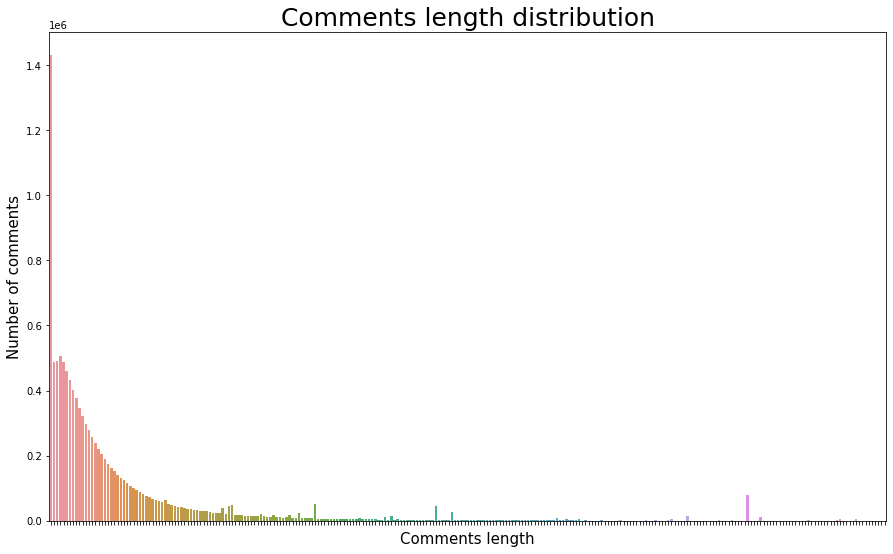

In [0]:
comments_length = comments_length.toPandas()
# Plot comments length distribution
plt.figure(figsize=(15,9))
# select only comments length with more than 200 occurrences
plot_1 = sns.barplot(x="comments_length", y="count", data=comments_length[comments_length['count'] > 200])
plot_1.set_title("Comments length distribution", fontsize=25)
plot_1.set_xlabel("Comments length", fontsize=15)
plot_1.set_ylabel("Number of comments", fontsize=15)
plot_1.set_xticklabels([])

plot_fpath = os.path.join("../../data/plots", "comments_length.png")
plt.savefig(plot_fpath)
plt.show()

Before proceeding to the NLP cleaning steps, let us examine the distribution of comments length. As comment length becomes longer, the counts gradually drop. Indicating that there exists a negative relationship between the number of comments and comment length. That suggests that the majority of comments are relatively short and people seldom write long comments in online social communities. The fact augments the difficulty for further tasks such as text classification. Since there might not exist enough context information for the model to decide which class the comments belong to.

Use TF-IDF to identify important words in comments.

In [0]:
from pyspark.ml.feature import CountVectorizer, IDF, Tokenizer
# perform TF-IDF
tokenizer = Tokenizer(inputCol="body", outputCol="words")
df_token = tokenizer.transform(top_pokemon)
# compute term frequency
cv = CountVectorizer(inputCol="words", outputCol="tf", vocabSize=10000, minDF=5)
cv_model=cv.fit(df_token)
df_tf = cv_model.transform(df_token)
# compute TF-IDF
idf=IDF(inputCol="tf", outputCol="tf_idf")
idf_model = idf.fit(df_tf)
df_tfidf = idf_model.transform(df_tf)
df_tfidf.show()

+--------------------+--------------------+-----------+-----+--------------------+--------------------+--------------------+
|           subreddit|                body|created_utc|score|               words|                  tf|              tf_idf|
+--------------------+--------------------+-----------+-----+--------------------+--------------------+--------------------+
|          PokemonTCG|taking the left s...| 1610125584|    1|[taking, the, lef...|(10000,[0,3,6,31,...|(10000,[0,3,6,31,...|
|             pokemon|         Chonki Boi!| 1610125592|    1|      [chonki, boi!]|       (10000,[],[])|       (10000,[],[])|
|PokemonSwordAndSh...|Which codes do yo...| 1610125602|    1|[which, codes, do...|(10000,[6,16,38,1...|(10000,[6,16,38,1...|
|       pokemontrades|I'm available to ...| 1610125605|    1|[i'm, available, ...|(10000,[3,4,8,21,...|(10000,[3,4,8,21,...|
|PokemonSwordAndSh...|Well as I said I ...| 1610125607|    1|[well, as, i, sai...|(10000,[1,3,4,8,9...|(10000,[1,3,4,8,9...|


Find out top 3 most important words for each comment. Due to the CountVectorizer, some words are not counted. Thus, its's possible that a comment doesn't contain any important words.

In [0]:
# vocabulary set
vocab = cv_model.vocabulary
# function to extract the most important words
def max_tfidf(features):
    text = features['body']
    vector = features['tf_idf']
    top3_index = np.argsort(vector)[::-1][:3]
    return (text, [vocab[index] for index in top3_index])
# show most important words by TF-IDF
tfidf_words = df_tfidf.select('body','tf_idf').rdd.map(lambda x: max_tfidf(x)).toDF(["body", "important_words"])
tfidf_words.show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------+
|body                                                                                                                                                                                        |important_words                  |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------+
|taking the left side art card any day. you young people dont know to appreciate the old times                                                                                               |[young, day., side]              |
|Chonki Boi!                                                                                        

### NLP Cleaning

For NLP cleaning, we perform following procedures.

 - Remove URL links
 - Remove ('s), ('ll), ('ve), ('m), ('re)
 - Remove punctuation and special characters
 - Remove extra white space
 - Tokenization
 - Normalize word frequencies
 - Remove stopwords
 - Lemmatization

In [0]:
from pyspark.ml import Pipeline
import sparknlp
from sparknlp.annotator import *
from sparknlp.base import *
import pyspark.sql.functions as f

In [0]:
pokemon_comments = spark.read.parquet("/FileStore/pokemon_comments")

# select top 5 subreddits
top5_subreddit = ["pokemongo",'pokemon','pokemontrades','PokemonTCG','PokemonSwordAndShield']
top_pokemon = pokemon_comments.filter(f.col("subreddit").isin(top5_subreddit)).select("subreddit", "body", "created_utc", "score")

Use regex to perform cleaning procedures.

In [0]:
# regex to identify most of url links
url = r'''(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'''
# remove url links
top_pokemon = top_pokemon.withColumn("body_clean", f.regexp_replace(f.col("body"), url, ""))
# remove 's, 'll, 've, 'm, 're
top_pokemon = top_pokemon.withColumn("body_clean", f.regexp_replace(f.col("body_clean"), r"'s\b|'ll\b|'ve\b|'m\b|'re\b", ""))
# remove special characters
top_pokemon = top_pokemon.withColumn("body_clean", f.regexp_replace(f.col("body_clean"), r"[\t\n\r\*\@\-\/]", " "))
# remove extra white spaces
top_pokemon = top_pokemon.withColumn("body_clean", f.regexp_replace(f.col("body_clean"), r"\s+", " "))

top_pokemon.show(5, truncate=False)

+---------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|subreddit            |body                                                                                                                                                                                        |created_utc|score|body_clean                                                                                                                                                                             |
+---------------------+---------------------------------------------------------------------------------------------------------------------------------------------------

Build sentiment model pipeline.

In [0]:
# build sentiment model pipeline
documentAssembler = DocumentAssembler() \
    .setInputCol("body_clean") \
    .setOutputCol("document")
# tokenization
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")
# normalize word frequencies
normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("token_normalized")
# remove stop words
stopwords_remover = StopWordsCleaner() \
    .setInputCols("token_normalized") \
    .setOutputCol("token_clean") \
    .setCaseSensitive(False)
# lemmatization
lemmatization = LemmatizerModel.pretrained('lemma_antbnc') \
    .setInputCols(["token_clean"]) \
    .setOutputCol("lemmatization")
# word embedding
wordEmbedding = WordEmbeddingsModel.pretrained() \
    .setInputCols(["document", "lemmatization"]) \
    .setOutputCol("word_embeddings") \
    .setCaseSensitive(False)
# sentence embedding 
sentenceEmbedding = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
    .setInputCols(["document", "word_embeddings"])\
    .setOutputCol("sentence_embeddings")
# sentiment model
sentimentModel = SentimentDLModel.pretrained(name="sentimentdl_use_twitter", lang="en")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")
# build pipeline
sentimentPipeline = Pipeline(
    stages = [documentAssembler,
              tokenizer,
              normalizer,
              stopwords_remover,
              lemmatization,
              wordEmbedding,
              sentenceEmbedding,
              sentimentModel])

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]
tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[OK!]


In [0]:
empty_df = spark.createDataFrame([['']]).toDF("body_clean")
pipelineModel = sentimentPipeline.fit(empty_df)

# transform data
sentiment_result = pipelineModel.transform(top_pokemon)

Extract sentiment result and join to the comments data

In [0]:
# extract sentiment result and join to the comments data
pokemon_sentiment = sentiment_result.select("subreddit", "body", "body_clean", "created_utc", "score", 
                                            f.explode("sentiment.result").alias("sentiment"))
pokemon_sentiment.show(10)

+--------------------+--------------------+--------------------+-----------+-----+---------+
|           subreddit|                body|          body_clean|created_utc|score|sentiment|
+--------------------+--------------------+--------------------+-----------+-----+---------+
|          PokemonTCG|taking the left s...|taking the left s...| 1610125584|    1| positive|
|             pokemon|         Chonki Boi!|         Chonki Boi!| 1610125592|    1| positive|
|PokemonSwordAndSh...|Which codes do yo...|Which codes do yo...| 1610125602|    1| positive|
|       pokemontrades|I'm available to ...|I available to tr...| 1610125605|    1| negative|
|PokemonSwordAndSh...|Well as I said I ...|Well as I said I ...| 1610125607|    1| positive|
|       pokemontrades|No problem!Have a...|No problem!Have a...| 1610125607|    1| positive|
|             pokemon|I really hope she...|I really hope she...| 1610125611|   76|  neutral|
|       pokemontrades|Okay I’m super su...|Okay I’m super su...| 16101

In [0]:
# save filtered sentiment result to file system
pokemon_sentiment.write.parquet("/FileStore/pokemon_comments_sentiment")